# Store Sales Forecasting

Predict sales for the thousands of product families sold at Favorita stores located in Ecuador. The training data includes dates, store and product information, whether that item was being promoted, as well as the sales numbers. Additional files include supplementary information that may be useful in building your models.

- **train.csv**
The training data, comprising time series of features store_nbr, family, and onpromotion as well as the target sales.
- **stores.csv**
Store metadata, including city, state, type, and cluster.
cluster is a grouping of similar stores.
-**oil.csv**
Daily oil price. 
-**holidays_events.csv**
Holidays and Events, with metadata


## Importing Libraries

In [ ]:
# For data preprocessing
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# To build visualizations
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Stats model to perfrom statistical analysis
from statsmodels.tsa.stattools import adfuller 
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm

## Data Loading

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/My Drive/Colab Notebooks/Project/store-sales-time-series-forecasting

/content/drive/My Drive/Colab Notebooks/Project/store-sales-time-series-forecasting


In [ ]:
train = pd.read_csv("train.csv")
stores = pd.read_csv("stores.csv")
oil = pd.read_csv("oil.csv")
transactions = pd.read_csv("transactions.csv")
holidays_events = pd.read_csv("holidays_events.csv")
test = pd.read_csv("test.csv")

In [ ]:
train.tail()

,id,date,store_nbr,family,sales,onpromotion
3000883,3000883,2017-08-15,9,POULTRY,438.133,0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8
3000887,3000887,2017-08-15,9,SEAFOOD,16.000,0


In [ ]:
train = train.merge(stores, how="left", on='store_nbr')   
train = train.merge(oil, how="left", on='date')      
train = train.merge(transactions, how="left", on=['date','store_nbr'])  
train = train.merge(holidays_events,on='date',how='left')
train = train.rename(columns={'type_x' : 'store_type','type_y':'holiday_type'})

test = test.merge(stores, how="left", on='store_nbr')   
test = test.merge(oil, how="left", on='date')      
test = test.merge(holidays_events,on='date',how='left')
test = test.rename(columns={'type_x' : 'store_type','type_y':'holiday_type'})

In [ ]:
train.tail(10)

,id,date,store_nbr,family,sales,onpromotion,city,state,store_type,cluster,dcoilwtico,transactions,holiday_type,locale,locale_name,description,transferred
3054338,3000878,2017-08-15,9,MAGAZINES,11.000,0,Quito,Pichincha,B,6,47.57,2155.0,Holiday,Local,Riobamba,Fundacion de Riobamba,False
3054339,3000879,2017-08-15,9,MEATS,449.228,0,Quito,Pichincha,B,6,47.57,2155.0,Holiday,Local,Riobamba,Fundacion de Riobamba,False
3054340,3000880,2017-08-15,9,PERSONAL CARE,522.000,11,Quito,Pichincha,B,6,47.57,2155.0,Holiday,Local,Riobamba,Fundacion de Riobamba,False
3054341,3000881,2017-08-15,9,PET SUPPLIES,6.000,0,Quito,Pichincha,B,6,47.57,2155.0,Holiday,Local,Riobamba,Fundacion de Riobamba,False
3054342,3000882,2017-08-15,9,PLAYERS AND ELECTRONICS,6.000,0,Quito,Pichincha,B,6,47.57,2155.0,Holiday,Local,Riobamba,Fundacion de Riobamba,False
3054343,3000883,2017-08-15,9,POULTRY,438.133,0,Quito,Pichincha,B,6,47.57,2155.0,Holiday,Local,Riobamba,Fundacion de Riobamba,False
3054344,3000884,2017-08-15,9,PREPARED FOODS,154.553,1,Quito,Pichincha,B,6,47.57,2155.0,Holiday,Local,Riobamba,Fundacion de Riobamba,False
3054345,3000885,2017-08-15,9,PRODUCE,2419.729,148,Quito,Pichincha,B,6,47.57,2155.0,Holiday,Local,Riobamba,Fundacion de Riobamba,False
3054346,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,Quito,Pichincha,B,6,47.57,2155.0,Holiday,Local,Riobamba,Fundacion de Riobamba,False
3054347,3000887,2017-08-15,9,SEAFOOD,16.000,0,Quito,Pichincha,B,6,47.57,2155.0,Holiday,Local,Riobamba,Fundacion de Riobamba,False


### 1.1 Check for null, duplicate records, and data leakage

**Observation**

- There are null values in the train and test dataset, namely the oil prices column and the holiday and events data
- No duplicates found in train and test datasets
- No leakage (record present in both train and test) found

In [ ]:
train.isnull().sum()

id                    0
date                  0
store_nbr             0
family                0
sales                 0
onpromotion           0
city                  0
state                 0
store_type            0
cluster               0
dcoilwtico       955152
transactions     249117
holiday_type    2551824
locale          2551824
locale_name     2551824
description     2551824
transferred     2551824
dtype: int64

In [ ]:
test.isnull().sum()

id                  0
date                0
store_nbr           0
family              0
onpromotion         0
city                0
state               0
store_type          0
cluster             0
dcoilwtico       7128
holiday_type    26730
locale          26730
locale_name     26730
description     26730
transferred     26730
dtype: int64

In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28512 entries, 0 to 28511
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            28512 non-null  int64  
 1   date          28512 non-null  object 
 2   store_nbr     28512 non-null  int64  
 3   family        28512 non-null  object 
 4   onpromotion   28512 non-null  int64  
 5   city          28512 non-null  object 
 6   state         28512 non-null  object 
 7   store_type    28512 non-null  object 
 8   cluster       28512 non-null  int64  
 9   dcoilwtico    21384 non-null  float64
 10  holiday_type  1782 non-null   object 
 11  locale        1782 non-null   object 
 12  locale_name   1782 non-null   object 
 13  description   1782 non-null   object 
 14  transferred   1782 non-null   object 
dtypes: float64(1), int64(4), object(10)
memory usage: 3.5+ MB


In [ ]:
dup = train[train.duplicated(subset=train.columns.tolist(), keep=False)]
print(f"Duplicate records in train: {dup.shape[0]}")

dup = test[test.duplicated(subset=test.columns.tolist(), keep=False)]
print(f"Duplicate records in test: {dup.shape[0]}")

Duplicate records in train: 0
Duplicate records in test: 0


In [ ]:
common_df = pd.merge(
    train,
    test,
    how='inner',
    on=test.columns.tolist()
)

print(f"Leakage records: {common_df.shape[0]}")
common_df.head()

Leakage records: 0


,id,date,store_nbr,family,sales,onpromotion,city,state,store_type,cluster,dcoilwtico,transactions,holiday_type,locale,locale_name,description,transferred


## Extracting date information

In [ ]:
train['date'] = pd.to_datetime(train['date'])
train['Quarter'] = train['date'].apply(lambda x: pd.to_datetime(x).quarter)
train['Week'] = train['date'].apply(lambda x: pd.to_datetime(x).week)
train['DayofWeek'] = train['date'].apply(lambda x: pd.to_datetime(x).dayofweek)
train['isWeekend'] = np.where(train['DayofWeek'].isin([5,6]),1,0)
train['Month'] = train['date'].apply(lambda x: pd.to_datetime(x).month)
train['Year'] = train['date'].apply(lambda x: pd.to_datetime(x).year)
train['Day'] = train['date'].apply(lambda x: pd.to_datetime(x).day)
train['season'] = train['Month'].apply(lambda x: 0 if x in [2,3] else 1 if x in [4,5,6] else 2 if x in [7,8] else 3 if x in [9,10,11] else 4)

train.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,store_type,cluster,...,description,transferred,Quarter,Week,DayofWeek,isWeekend,Month,Year,Day,season
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,...,Primer dia del ano,False,1,1,1,0,1,2013,1,4
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,...,Primer dia del ano,False,1,1,1,0,1,2013,1,4
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,...,Primer dia del ano,False,1,1,1,0,1,2013,1,4
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,...,Primer dia del ano,False,1,1,1,0,1,2013,1,4
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,...,Primer dia del ano,False,1,1,1,0,1,2013,1,4


In [ ]:
test['date'] = pd.to_datetime(train['date'])
test['Quarter'] = test['date'].apply(lambda x: pd.to_datetime(x).quarter)
test['Week'] = test['date'].apply(lambda x: pd.to_datetime(x).week)
test['DayofWeek'] = test['date'].apply(lambda x: pd.to_datetime(x).dayofweek)
test['isWeekend'] = np.where(test['DayofWeek'].isin([5,6]),1,0)
test['Month'] = test['date'].apply(lambda x: pd.to_datetime(x).month)
test['Year'] = test['date'].apply(lambda x: pd.to_datetime(x).year)
test['Day'] = test['date'].apply(lambda x: pd.to_datetime(x).day)
test['season'] = test['Month'].apply(lambda x: 0 if x in [2,3] else 1 if x in [4,5,6] else 2 if x in [7,8] else 3 if x in [9,10,11] else 4)
test.head()

,id,date,store_nbr,family,onpromotion,city,state,store_type,cluster,dcoilwtico,...,description,transferred,Quarter,Week,DayofWeek,isWeekend,Month,Year,Day,season
0,3000888,2013-01-01,1,AUTOMOTIVE,0,Quito,Pichincha,D,13,46.8,...,NaN,NaN,1,1,1,0,1,2013,1,4
1,3000889,2013-01-01,1,BABY CARE,0,Quito,Pichincha,D,13,46.8,...,NaN,NaN,1,1,1,0,1,2013,1,4
2,3000890,2013-01-01,1,BEAUTY,2,Quito,Pichincha,D,13,46.8,...,NaN,NaN,1,1,1,0,1,2013,1,4
3,3000891,2013-01-01,1,BEVERAGES,20,Quito,Pichincha,D,13,46.8,...,NaN,NaN,1,1,1,0,1,2013,1,4
4,3000892,2013-01-01,1,BOOKS,0,Quito,Pichincha,D,13,46.8,...,NaN,NaN,1,1,1,0,1,2013,1,4


## Missing Values Handling

### 2.1 Oil Price

- Oil price data is daily price data so that missing values can be filled using the backward fill method

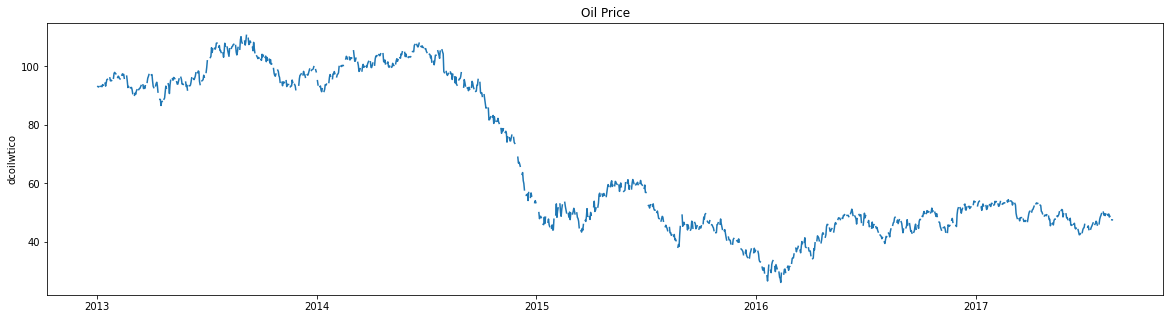

In [ ]:
oil_mis = train.set_index("date").dcoilwtico.resample("D").mean().reset_index()
plt.rcParams['figure.figsize'] = (20, 5)
plt.title('Oil Price')
plt.ylabel('dcoilwtico')
plt.plot(oil_mis['date'],oil_mis['dcoilwtico']);

In [ ]:
train['dcoilwtico'] = train['dcoilwtico'].fillna(method='bfill')
train.dcoilwtico.isnull().sum()

0

In [ ]:
test['dcoilwtico'] = test['dcoilwtico'].fillna(method='bfill')
test.dcoilwtico.isnull().sum()

0

### 1.2 Transactions

- Null values in the transaction data indicate that there were no store and product family sales transactions on that day

In [ ]:
train.transactions = train.transactions.replace(np.nan,0)

### 1.3 Holiday Events

- Null values in the holiday type can be assumed that the day is a work day.

In [ ]:
train[['locale','locale_name', 'description']] = train[['locale','locale_name', 'description']].replace(np.nan,'')
train['holiday_type'] = train['holiday_type'].replace(np.nan,'Work Day')
train['transferred'] = train['transferred'].replace(np.nan,False)

In [ ]:
train.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,store_type,cluster,...,description,transferred,Quarter,Week,DayofWeek,isWeekend,Month,Year,Day,season
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,...,Primer dia del ano,False,1,1,1,0,1,2013,1,4
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,...,Primer dia del ano,False,1,1,1,0,1,2013,1,4
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,...,Primer dia del ano,False,1,1,1,0,1,2013,1,4
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,...,Primer dia del ano,False,1,1,1,0,1,2013,1,4
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,...,Primer dia del ano,False,1,1,1,0,1,2013,1,4


In [ ]:
test[['locale','locale_name', 'description']] = test[['locale','locale_name', 'description']].replace(np.nan,'')
test['holiday_type'] = test['holiday_type'].replace(np.nan,'Work Day')
test['transferred'] = test['transferred'].replace(np.nan,False)

## EDA



### Examine Target Variable (Sales)

**Observations**
- The highest average sales occur at the end of the month (due to holidays), end of the weekend, and beginning of the month (due to payday and supplies for the month)
- The lowest sales occurred in the middle of the week

In [ ]:
train = train.reset_index()

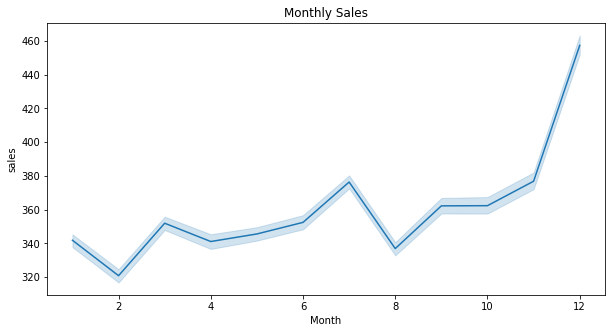

In [ ]:
plt.figure(figsize=(10, 5))
sns.lineplot(x='Month', y='sales', data=train)
plt.title("Monthly Sales");

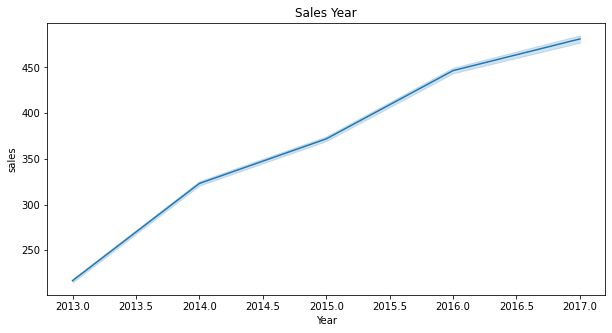

In [ ]:
plt.figure(figsize=(10, 5))
sns.lineplot(x='Year', y='sales', data=train)
plt.title("Sales by Year");

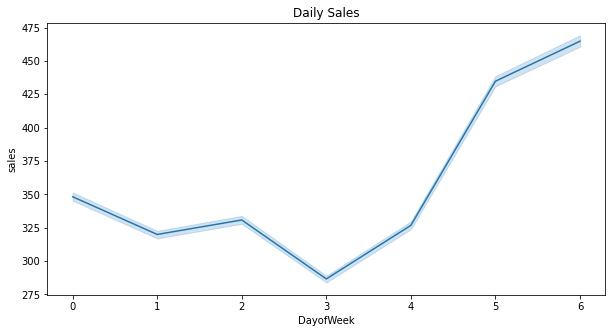

In [ ]:
plt.figure(figsize=(10, 5))
sns.lineplot(x='DayofWeek', y='sales', data=train)
plt.title("Daily Sales");

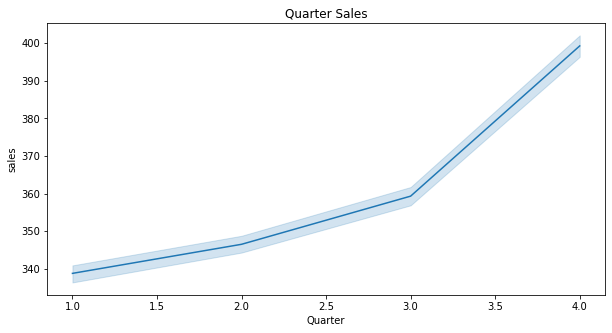

In [ ]:
plt.figure(figsize=(10, 5))
sns.lineplot(x='Quarter', y='sales', data=train)
plt.title("Quarter Sales");

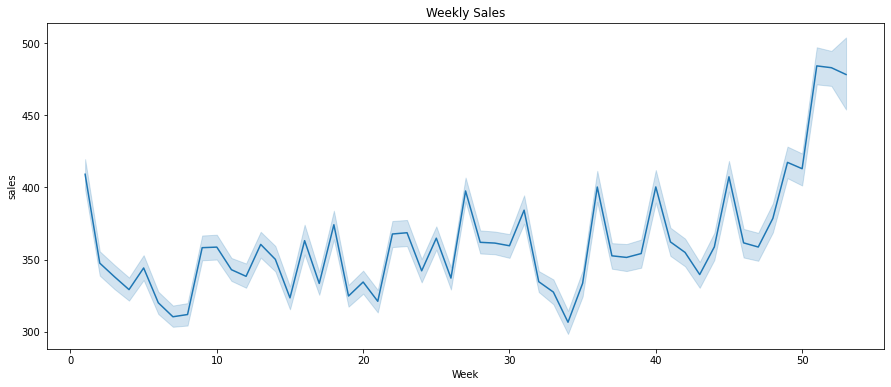

In [ ]:
plt.figure(figsize=(15, 6))
sns.lineplot(x='Week', y='sales', data=train)
plt.title("Weekly Sales");

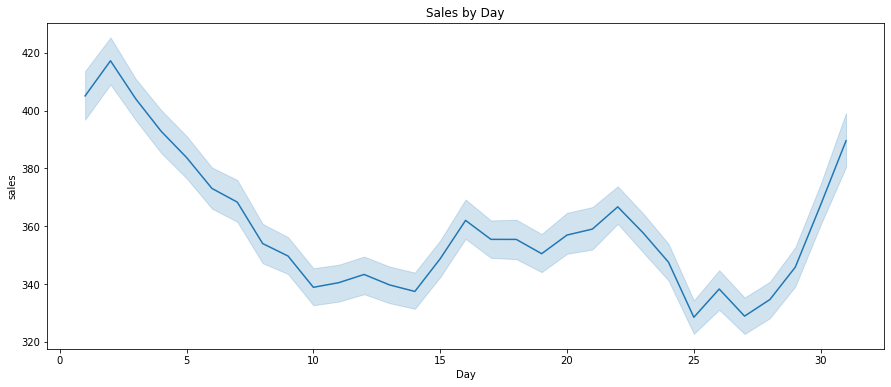

In [ ]:
plt.figure(figsize=(15, 6))
sns.lineplot(x='Day', y='sales', data=train)
plt.title("Sales by Day");

### Transactions

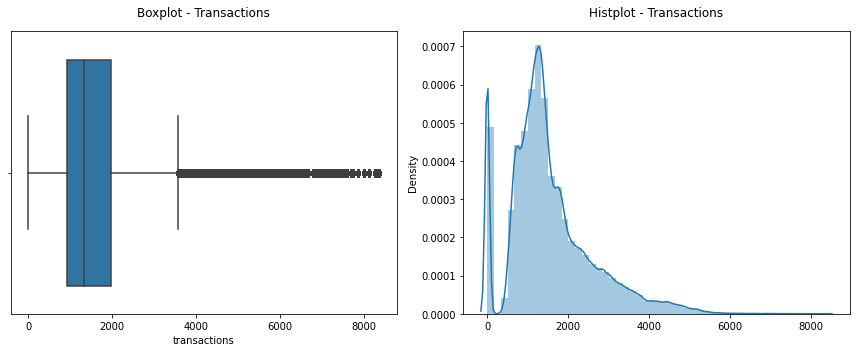

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.boxplot(x='transactions', data=train, ax=ax[0])
sns.distplot(x=train['transactions'],  ax=ax[1])
ax[0].set_title(f"Boxplot - Transactions", pad=15)
ax[1].set_title(f"Histplot - Transactions", pad=15)
fig.tight_layout();

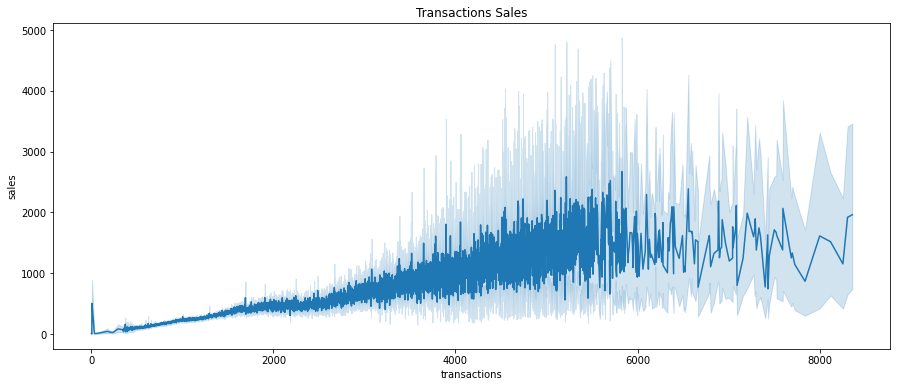

In [ ]:
plt.figure(figsize=(15, 6))
sns.lineplot(x='transactions', y='sales', data=train)
plt.title("Transactions Sales");

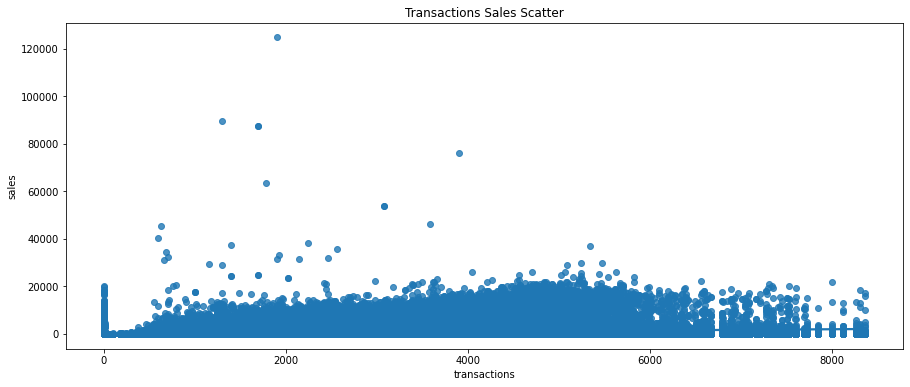

In [ ]:
plt.figure(figsize=(15, 6))
sns.regplot(x='transactions', y='sales', data=train)
plt.title("Transactions Sales Scatter");

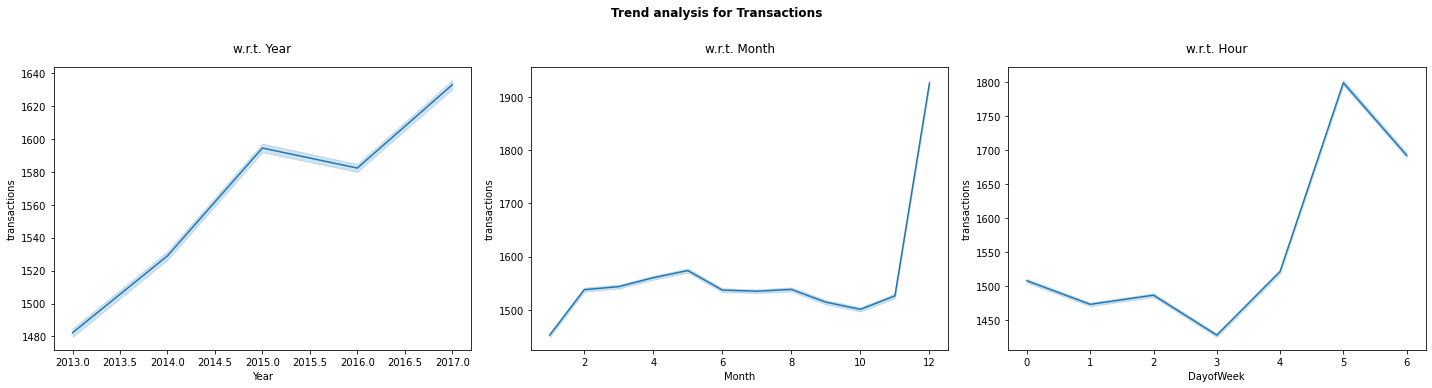

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
sns.lineplot(x='Year', y='transactions', data=train, ax=ax[0])
sns.lineplot(x='Month', y='transactions', data=train, ax=ax[1])
sns.lineplot(x='DayofWeek', y='transactions', data=train, ax=ax[2])
ax[0].set_title('w.r.t. Year', pad=15)
ax[1].set_title('w.r.t. Month', pad=15)
ax[2].set_title('w.r.t. Hour', pad=15)
fig.tight_layout()
plt.suptitle("Trend analysis for Transactions",
             y=1.07, fontweight='bold');

### Oil Price

**Observations**
- It can be seen that the daily oil price has a very weak correlation to the number of transactions and the number of sales.
- However, from the scatter plot graph between transactions and sales, it can be seen that there are 2 differences in sales when the oil price is more or less than 70.

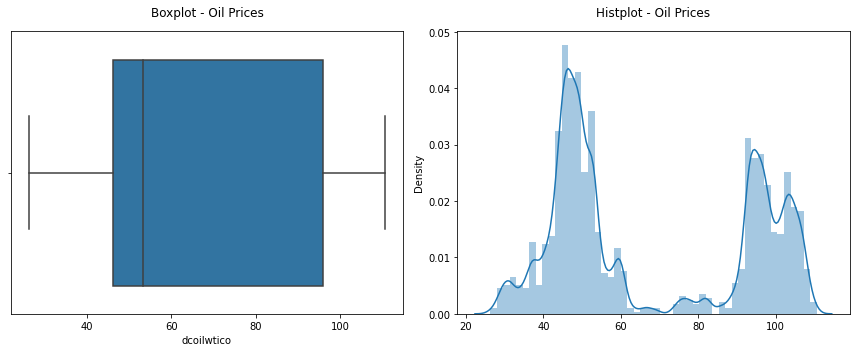

In [ ]:
from pyparsing import traceParseAction
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.boxplot(x='dcoilwtico', data=train, ax=ax[0])
sns.distplot(x=train['dcoilwtico'],  ax=ax[1])
ax[0].set_title(f"Boxplot - Oil Prices", pad=15)
ax[1].set_title(f"Histplot - Oil Prices", pad=15)
fig.tight_layout();

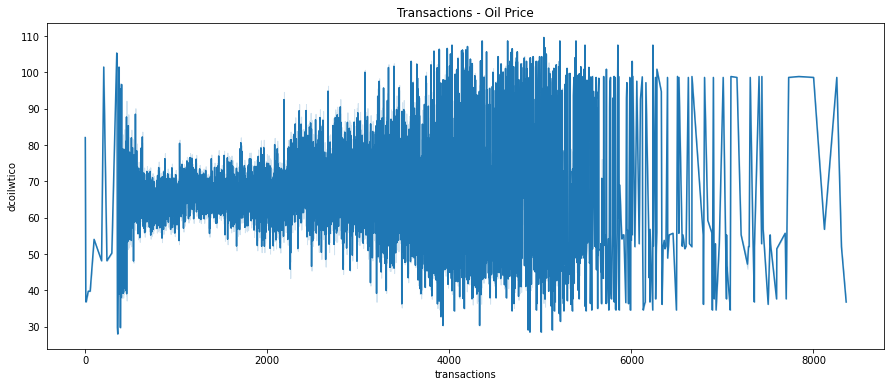

In [ ]:
plt.figure(figsize=(15, 6))
sns.lineplot(x='dcoilwtico', y='transactions', data=train)
plt.title("Transactions - Oil Price");

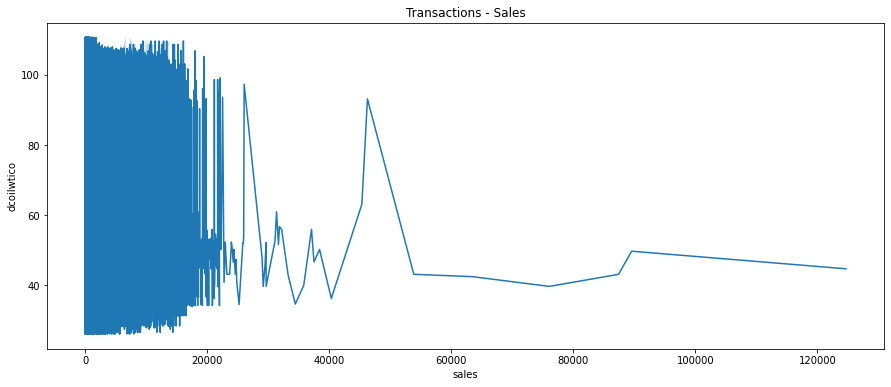

In [ ]:
plt.figure(figsize=(15, 6))
sns.lineplot(x='dcoilwtico', y='sales', data=train)
plt.title("Sales - Oil Price");

Correlation with Daily Oil Prices
sales          -0.182189
transactions   -0.042283
Name: dcoilwtico, dtype: float64


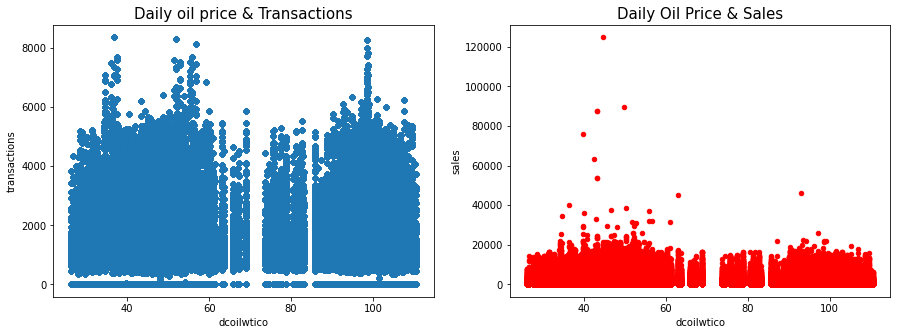

In [ ]:
print("Correlation with Daily Oil Prices")
print(train.corr("spearman").dcoilwtico.loc[["sales", "transactions"]])

fig, axes = plt.subplots(1, 2, figsize = (15,5))
train.plot.scatter(x = "dcoilwtico", y = "transactions", ax=axes[0])
train.plot.scatter(x = "dcoilwtico", y = "sales", ax=axes[1], color = "r")
axes[0].set_title('Daily oil price & Transactions', fontsize = 15)
axes[1].set_title('Daily Oil Price & Sales', fontsize = 15);

### Product Family

- Grocery 1, beverages, produce, cleaning, and diary are the top 5 product based on sales.

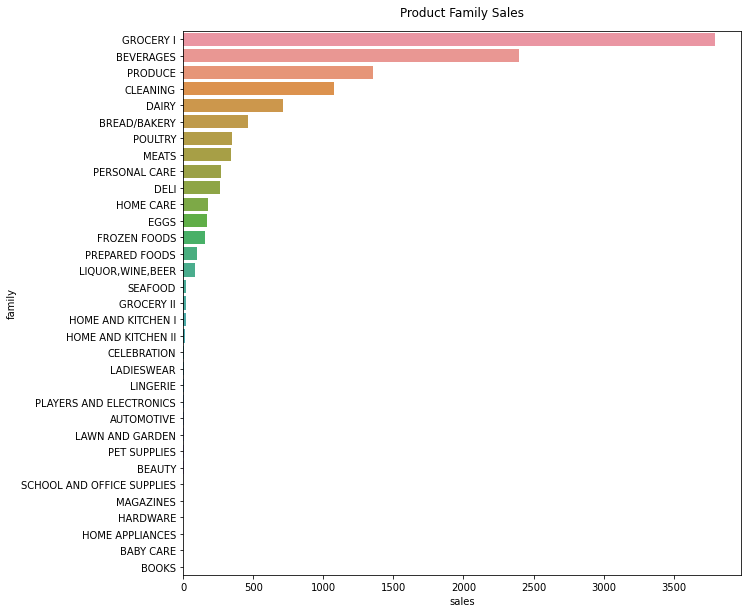

In [ ]:
product_sales = train.groupby("family").sales.mean().sort_values(ascending = False).reset_index()
plt.figure(figsize=(10, 10))
sns.barplot(y='family', x='sales', data=product_sales)
plt.title("Product Family Sales", pad=15);

**Observations**
- The highest average sales occur during national holidays and on additional holidays.
- type A stores have the highest average sales compared to other types of stores.
- These features can be used as ordinal data types based on their sales

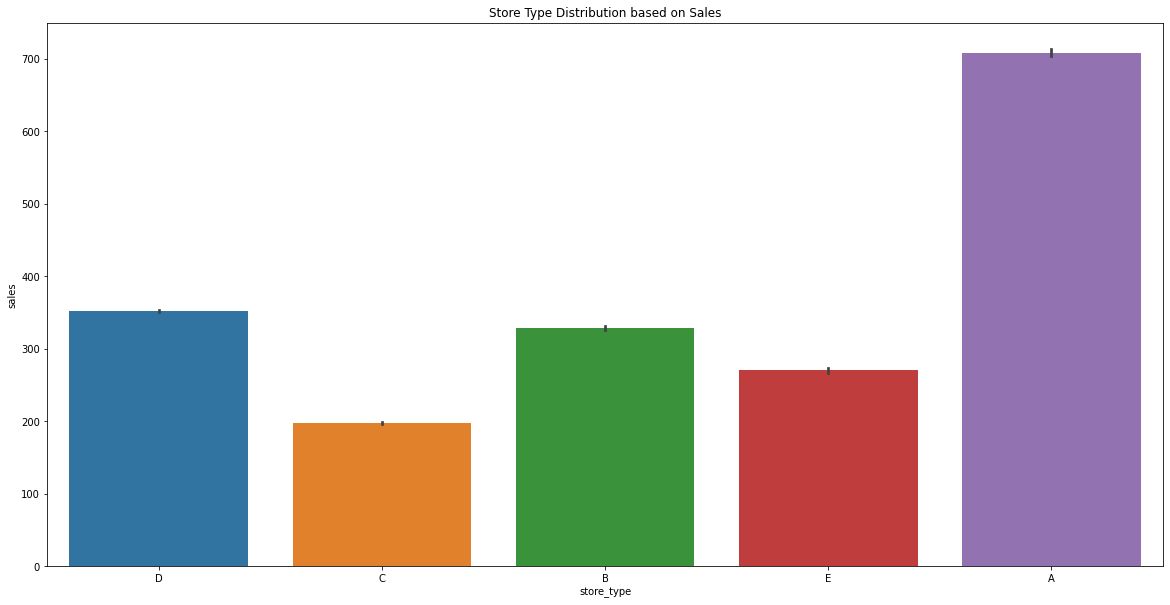

In [ ]:
plt.figure(figsize=(20,10))
sns.barplot(x="store_type", y="sales", data=train)
plt.title('Store Type Distribution based on Sales')
plt.show()

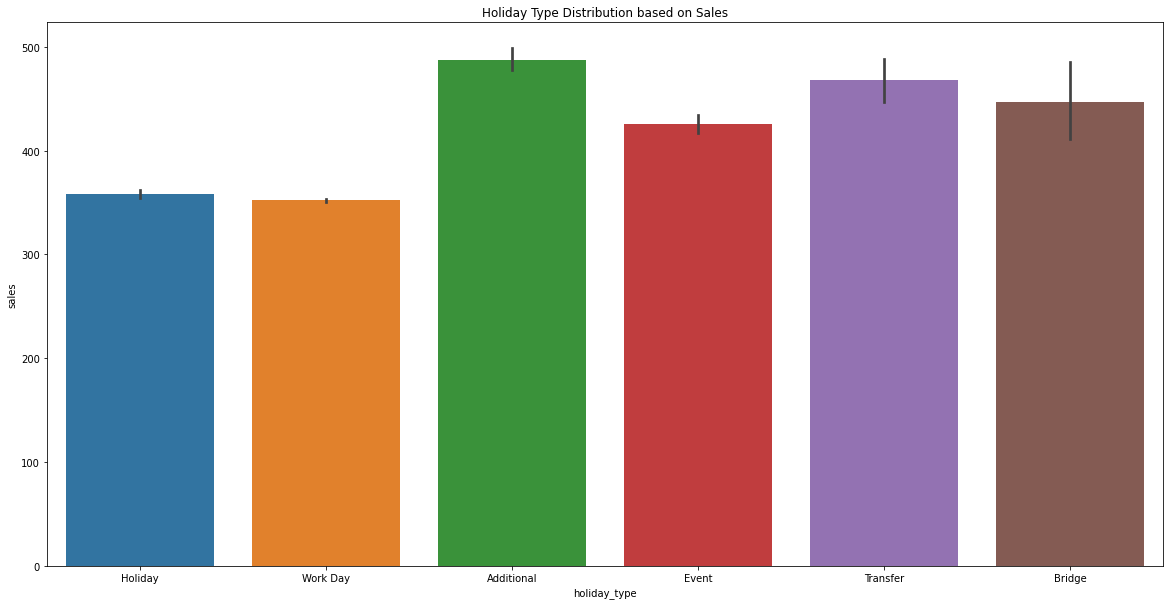

In [ ]:
plt.figure(figsize=(20,10))
sns.barplot(x="holiday_type", y="sales", data=train)
plt.title('Holiday Type Distribution based on Sales')
plt.show()

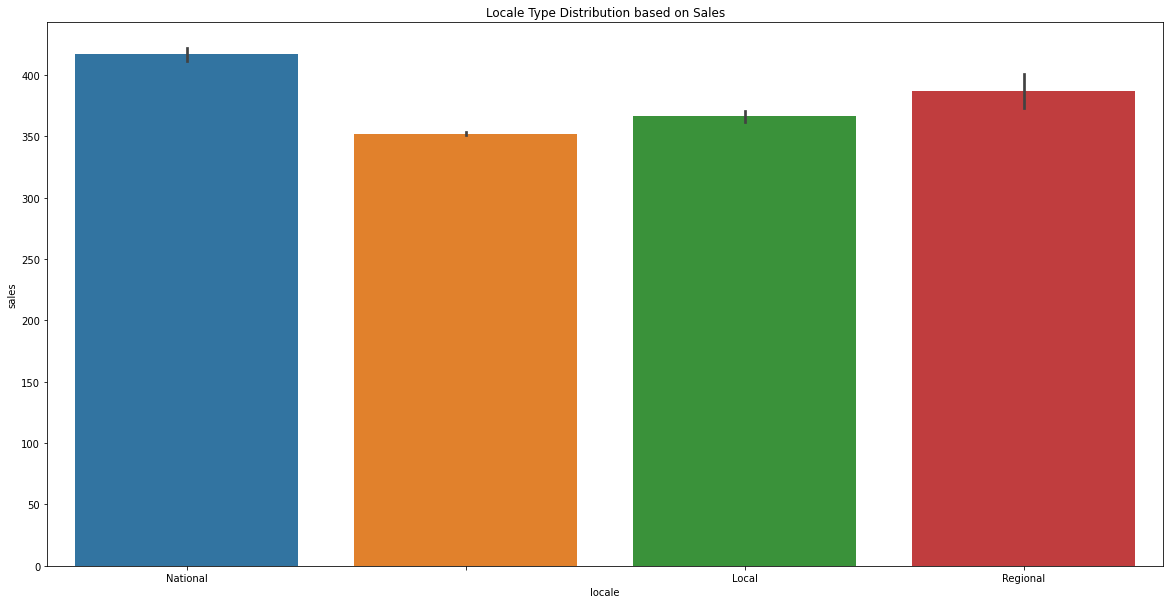

In [ ]:
plt.figure(figsize=(20,10))
sns.barplot(x="locale", y="sales", data=train)
plt.title('Locale Type Distribution based on Sales')
plt.show()

In [ ]:
storetype_values = {'A':5, 'D':4, 'B':3, 'E':2, 'C':1}
train['store_type'] = train.store_type.map(storetype_values)
test['store_type'] = test.store_type.map(storetype_values)

In [ ]:
holidaytype_values = {'Additional':6, 'Transfer':5, 'Bridge':4, 'Event':3, 'Holiday':2, 'Work Day':1}
train['holiday_type'] = train.holiday_type.map(holidaytype_values)
test['holiday_type'] = test.holiday_type.map(holidaytype_values)

In [ ]:
locale_values = {'National':4, 'Regional':3, 'Local':2, '':1}
train['locale'] = train.locale.map(locale_values)
test['locale'] = test.locale.map(locale_values)

### Store

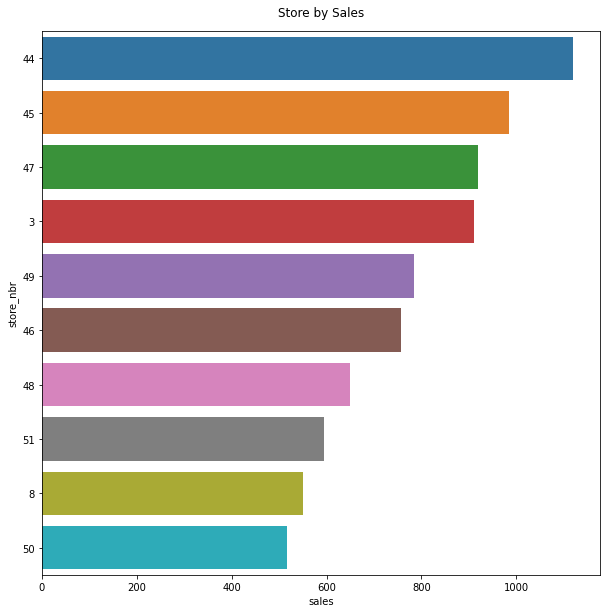

In [ ]:
store_sales = train.groupby("store_nbr").sales.mean().sort_values(ascending = False).reset_index()
store_sales['store_nbr'] = store_sales['store_nbr'].astype('category')
plt.figure(figsize=(10, 10))
sns.barplot(y='store_nbr', x='sales', data=store_sales, order=store_sales.sort_values('sales', ascending=False).store_nbr[0:10])
plt.title("Store by Sales", pad=15);

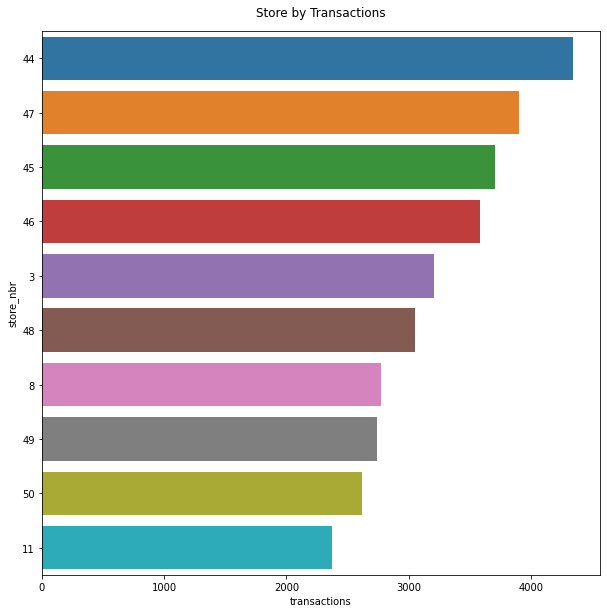

In [ ]:
store_transactions = train.groupby("store_nbr").transactions.mean().sort_values(ascending = False).reset_index()
store_transactions['store_nbr'] = store_transactions['store_nbr'].astype('category')
plt.figure(figsize=(10, 10))
sns.barplot(y='store_nbr', x='transactions', data=store_transactions, order=store_transactions.sort_values('transactions', ascending=False).store_nbr[0:10])
plt.title("Store by Transactions", pad=15);

In [ ]:
#Stores on top 10 that have both the highest transaction value and sales
sales_trans = store_sales[0:10].merge(store_transactions[0:10], how='inner', on='store_nbr')
sales_trans

,store_nbr,sales,transactions
0,44,1120.118405,4344.697715
1,45,984.565998,3705.516696
2,47,919.777871,3903.990041
3,3,911.098054,3207.634818
4,49,784.039156,2735.908612
5,46,756.775349,3581.073814
6,48,649.584599,3054.663738
7,8,550.264615,2769.988277
8,50,517.551554,2620.762156


## Time Series Analysis

- The data is almost normally distributed based on the probability plot.
- p-value less than 0.05, Null hypothesis stands true and time series is not stationary. data must be changed to stationary for forecasting.
- PACF plot shows the number of lags used as a parameter for modeling.

In [ ]:
sales = train.groupby('date').agg({"sales" : "mean"}).reset_index()
sales.set_index('date',inplace=True)

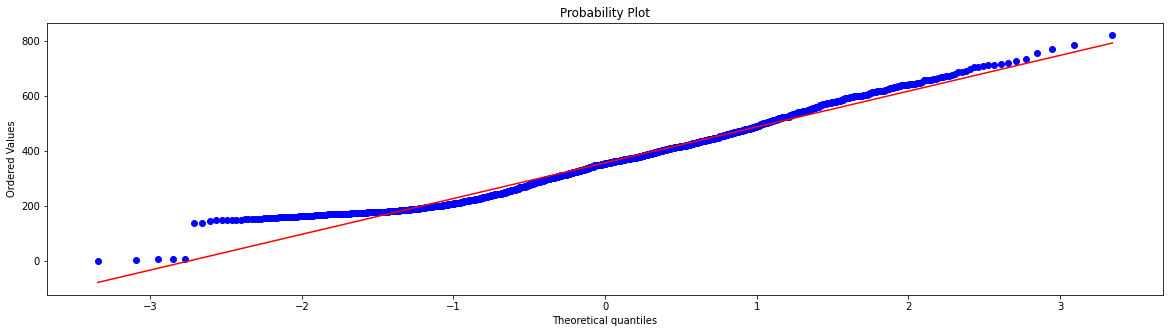

In [ ]:
scipy.stats.probplot(sales.sales,plot=pylab)
pylab.show()

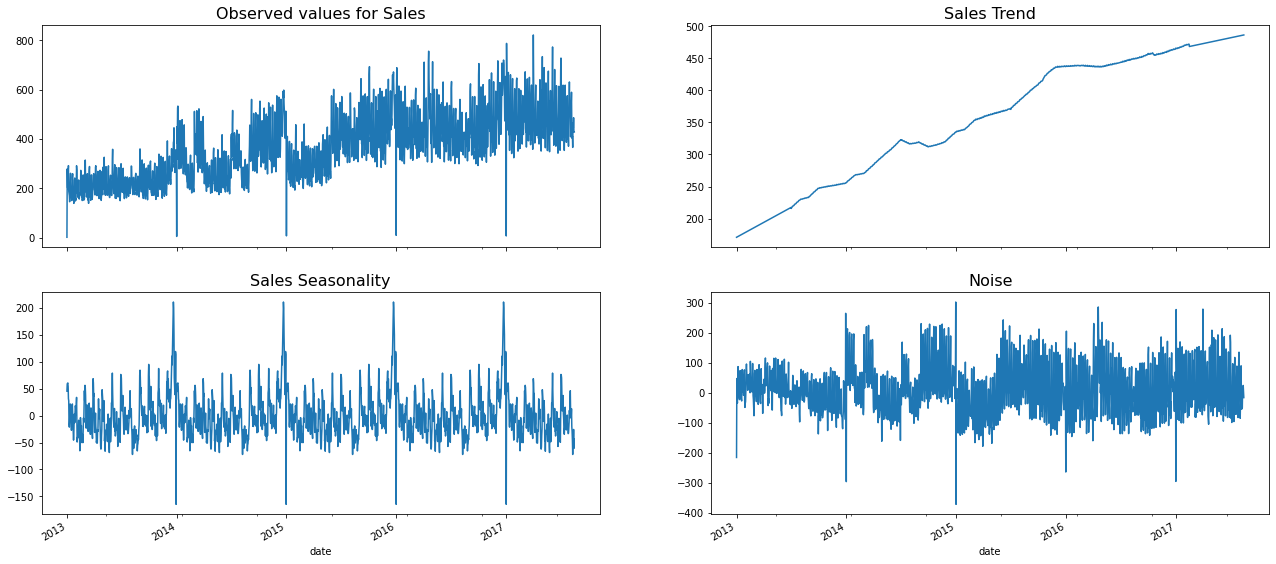

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomp = seasonal_decompose(sales['sales'], period=365, model='additive', extrapolate_trend='freq')
fig, ax = plt.subplots(ncols=2, nrows=2, sharex=True, figsize=(22,10))
ax[0,0].set_title('Observed values for Sales', fontsize=16)
decomp.observed.plot(ax = ax[0,0], legend=False)

ax[0,1].set_title('Sales Trend', fontsize=16)
decomp.trend.plot(ax = ax[0,1],legend=False)

ax[1,0].set_title('Sales Seasonality', fontsize=16)
decomp.seasonal.plot(ax = ax[1,0],legend=False)

ax[1,1].set_title('Noise', fontsize=16)
decomp.resid.plot(ax = ax[1,1],legend=False)

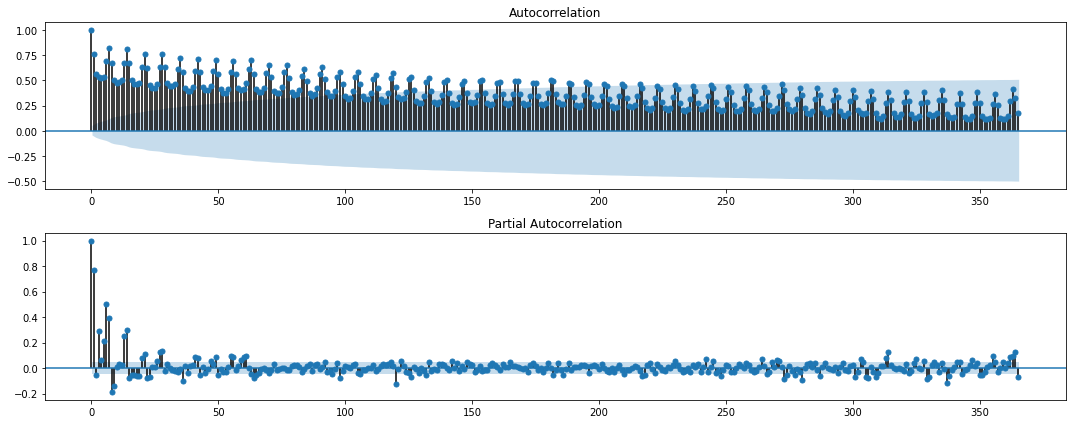

In [ ]:
fig,ax = plt.subplots(2,1, figsize=(15, 6))
fig = sm.tsa.graphics.plot_acf(sales['sales'], lags=365, ax=ax[0])
fig = sm.tsa.graphics.plot_pacf(sales['sales'], lags=365, ax=ax[1])
fig.tight_layout()

In [ ]:
# check for stationarity
def adf_test(series, title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print('Augmented Dickey-Fuller Test: {}'.format(title))
    # .dropna() handles differenced data
    result = adfuller(series.dropna(),autolag='AIC') 
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out['critical value ({})'.format(key)]=val
        
    # .to_string() removes the line "dtype: float64"
    print(out.to_string())          
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [ ]:
adf_test(sales['sales'],title='') 

Augmented Dickey-Fuller Test: 
ADF test statistic        -2.616196
p-value                    0.089696
# lags used               22.000000
# observations          1661.000000
critical value (1%)       -3.434293
critical value (5%)       -2.863282
critical value (10%)      -2.567697
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


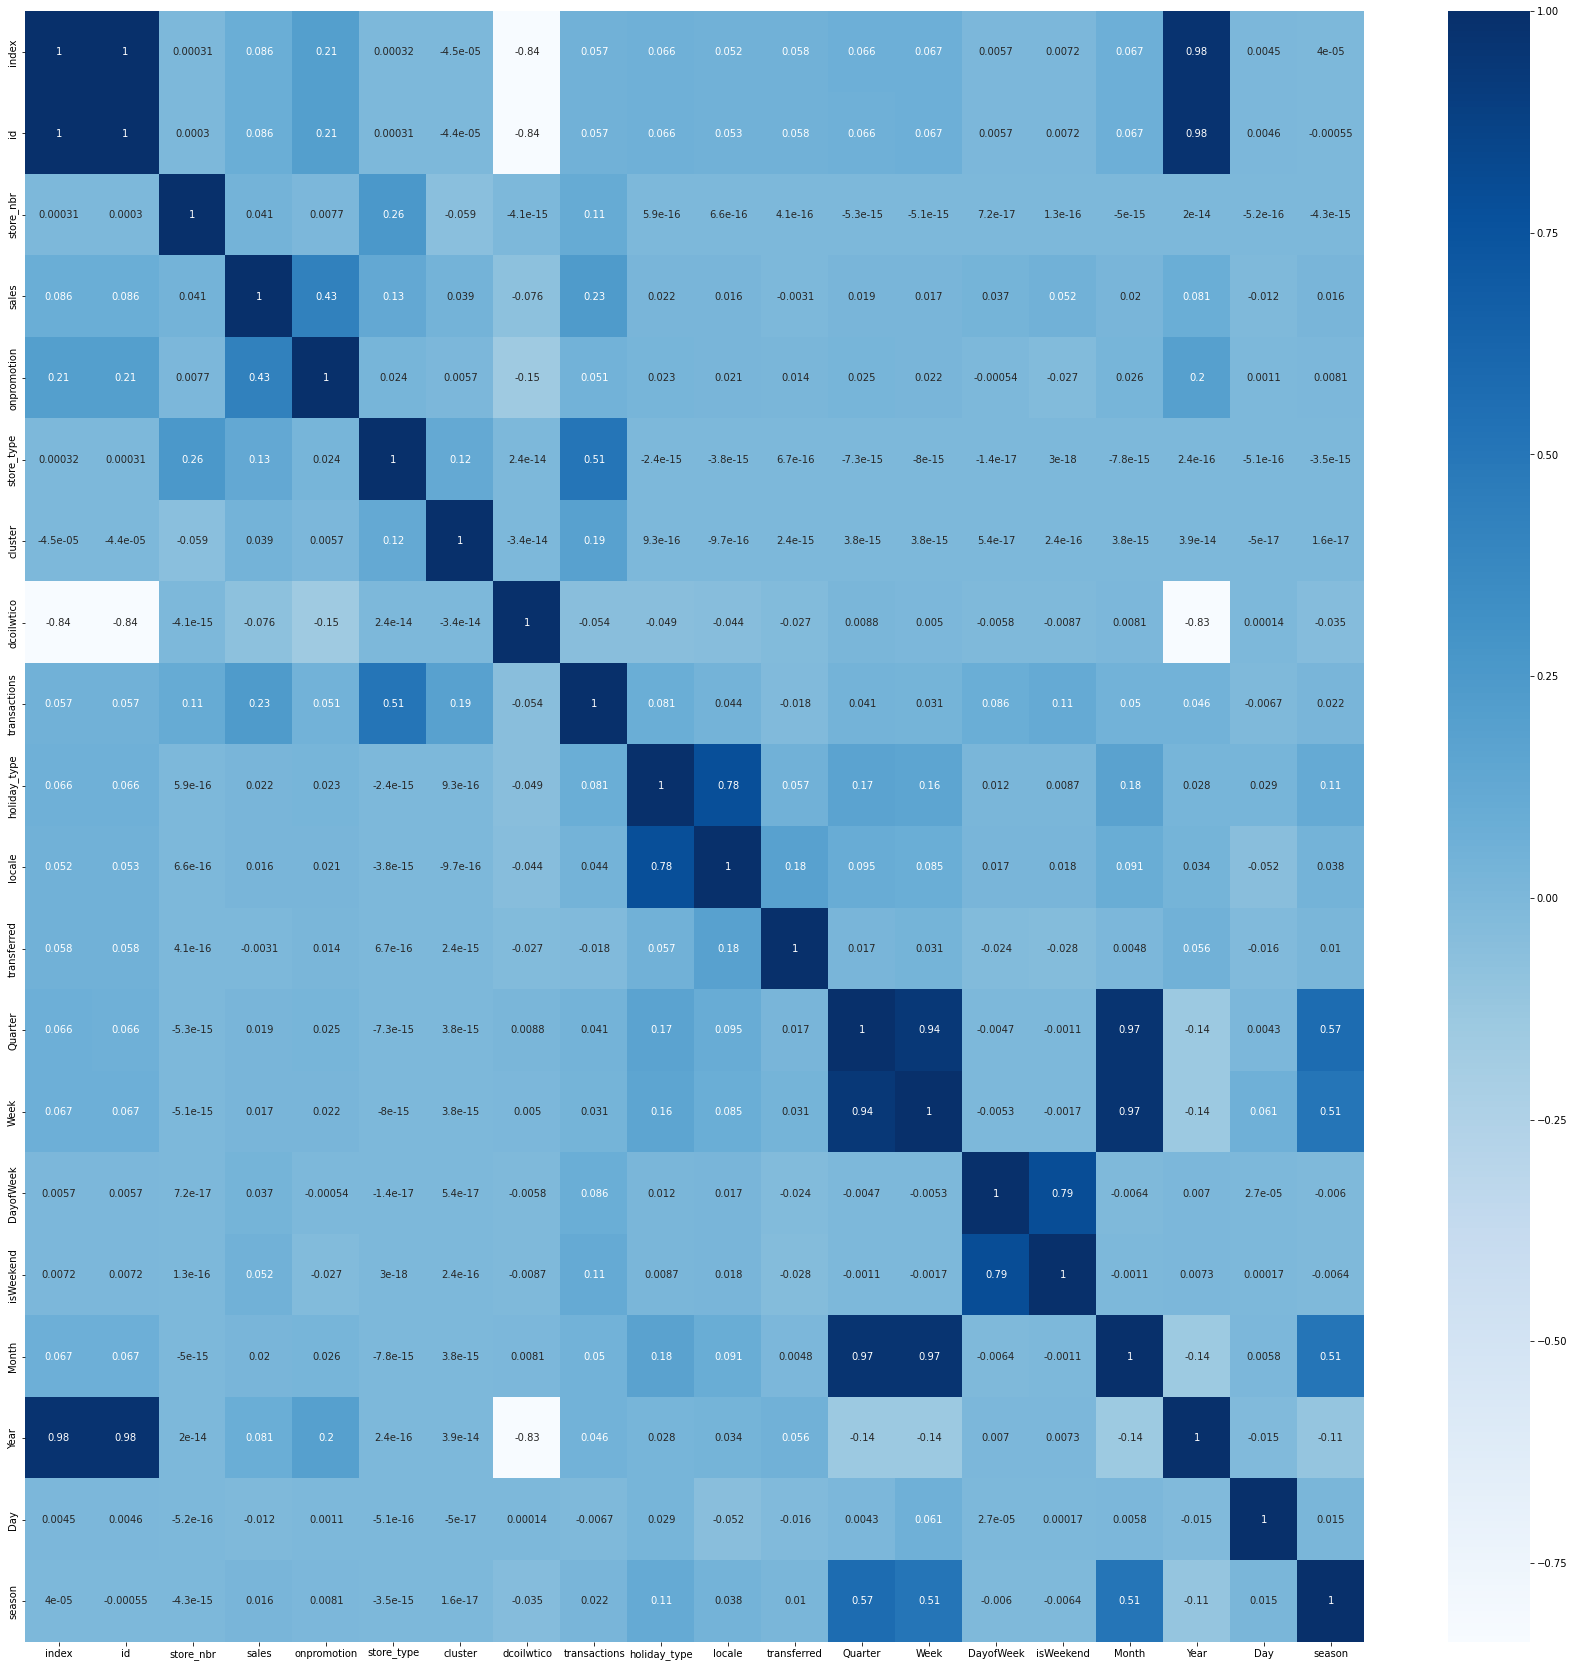

In [ ]:
plt.figure(figsize=(30,30))
sns.heatmap(train.corr(),cbar=True,annot=True,cmap='Blues')